Import libraries

In [1]:
import os 
import copy
import collections
import numpy as np 
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt 

import torch

from utils import load_pickle, pickle_data

Rough idea: 

    - In this part of the analysis, we look at the worst mistakes made by all the models and try to understand how data can potentially harm predictions 
    - We start with the hypothesis that having good coverage is helpful
        - To this effect, we look at how IDENTICAL molecules can affect the performance

Settings

In [2]:
top_k = 1000
cache_folder = "./cache"
IF_cache_folder = os.path.join(cache_folder, "IF_results")
IF_plots_folder = os.path.join(IF_cache_folder, "IF_plots")
if not os.path.exists(IF_cache_folder): os.makedirs(IF_cache_folder)
if not os.path.exists(IF_plots_folder): os.makedirs(IF_plots_folder)

baseline_models_folder = "../FP_prediction/baseline_models/best_models"
mist_folder = "../FP_prediction/mist/best_models"

data_folder = Path("/data/rbg/users/klingmin/projects/MS_processing/data")
results_folder = []

for folder in [mist_folder, baseline_models_folder]:
    for dataset in os.listdir(folder):
        for checkpoint in os.listdir(os.path.join(folder, dataset)):
            if "sieved" in checkpoint: continue
            if "sampled_random" in dataset: continue
            if "sampled_remove_top_k_harmful" in dataset: continue
            results_folder.append(os.path.join(folder, dataset, checkpoint))

diff_expt_conditions = ["diff_adduct", "diff_instrument", "diff_CE",
                        "diff_adduct_instrument", "diff_adduct_CE",
                        "diff_instrument_CE", "diff_adduct_instrument_CE"]

model_mapping = {"binned_": "Binned \n MLP",
                 "MS_": "MS \n Transformer",
                 "formula_": "Formula \n Transformer",
                 "MIST_": "MIST"}

dataset_mapping = {"C": "CANOPUS",
                   "MSG": "MassSpecGym",
                   "NIST2023": "NIST2023"}

split_mapping = {"scaffold_vanilla": "Scaffold split",
                 "inchikey_vanilla": "InChIKey split",
                 "random": "Random split",
                 "LS": "LS split"}

harmful_color_code, helpful_color_code = "#A8D0DB", "#83858C"

Helper Functions

`` We want to support results from LS ``

    1. We show that identical molecules can be harmful
    2. We show that identical molecules coming from different experimental conditions can be harmful

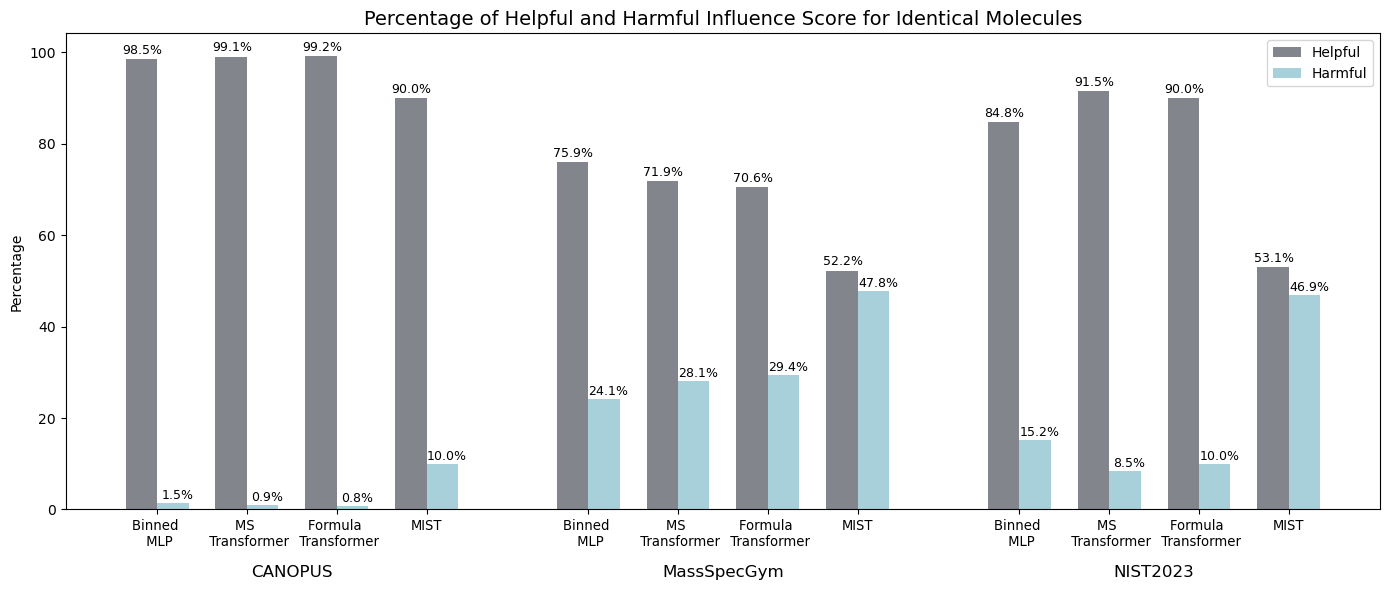

In [3]:
results_cache = [f for f in os.listdir(IF_cache_folder) if "random" in f]

datasets = ["C", "MSG", "NIST2023"]
models = ["binned_", "MS_", "formula_", "MIST_"] #"binned_", "MS_", "formula_", 

# Get the percentage positive and negative for identical molecules for each model and dataset 
helpful_percent, harmful_percent = [], []

for dataset in datasets:

    for model in models: 

        results_path = [f for f in results_cache if dataset in f and model in f if "sieved" not in f]
        assert len(results_path) == 1
        results_path = os.path.join(IF_cache_folder, results_path[0], "identical_mol_helpful_harmful_counts.pkl")
        results = load_pickle(results_path)

        helpful = np.mean([v["helpful"] for v in results.values()]).item()
        harmful = np.mean([v["harmful"] for v in results.values()]).item()
        helpful_percent.append(round(helpful * 100, 3))
        harmful_percent.append(round(harmful * 100, 3))

helpful_percent = np.array(helpful_percent).reshape(len(datasets), len(models))
harmful_percent = np.array(harmful_percent).reshape(len(datasets), len(models))

# Parameters
bar_width = 0.35
bar_spacing = 1.0
group_spacing = 0.8
n_models = len(models)

# Compute positions
x_positions = []
model_labels = []
dataset_boundaries = []

for d_idx, dataset in enumerate(datasets):
    group_start = d_idx * (n_models * bar_spacing + group_spacing)
    group_centers = []

    for m_idx, model in enumerate(models):
        center = group_start + m_idx * bar_spacing + (bar_width / 2)
        x_positions.append(center)
        model_labels.append(model_mapping[model])
        group_centers.append(center)

    dataset_boundaries.append(np.mean(group_centers))

# Flatten data
pos_flat = [p for group in helpful_percent for p in group]
neg_flat = [n for group in harmful_percent for n in group]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

x_positions = np.array(x_positions)
ax.bar(x_positions - bar_width/2, pos_flat, bar_width, label='Helpful', color= helpful_color_code)
ax.bar(x_positions + bar_width/2, neg_flat, bar_width, label='Harmful', color= harmful_color_code)

# Main x-axis: model labels
ax.set_xticks(x_positions)
ax.set_xticklabels(model_labels, fontsize = 9.5)
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Helpful and Harmful Influence Score for Identical Molecules', fontsize=14)
ax.legend()

# Secondary x-axis for dataset grouping
ax2 = ax.secondary_xaxis('bottom')
ax2.set_xticks(dataset_boundaries)
ax2.set_xticklabels([dataset_mapping[d] for d in datasets])
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(axis='x', length=0, pad=40, labelsize=12)

# Add text labels
for xpos, height in zip(x_positions - bar_width/2, pos_flat):
    ax.text(xpos + 0.01, height + 0.5, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

for xpos, height in zip(x_positions + bar_width/2, neg_flat):
    ax.text(xpos + 0.05, height + 0.2, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(IF_plots_folder, "IF_identical_mol_helpful_harmful.png"), bbox_inches='tight')

plt.show()

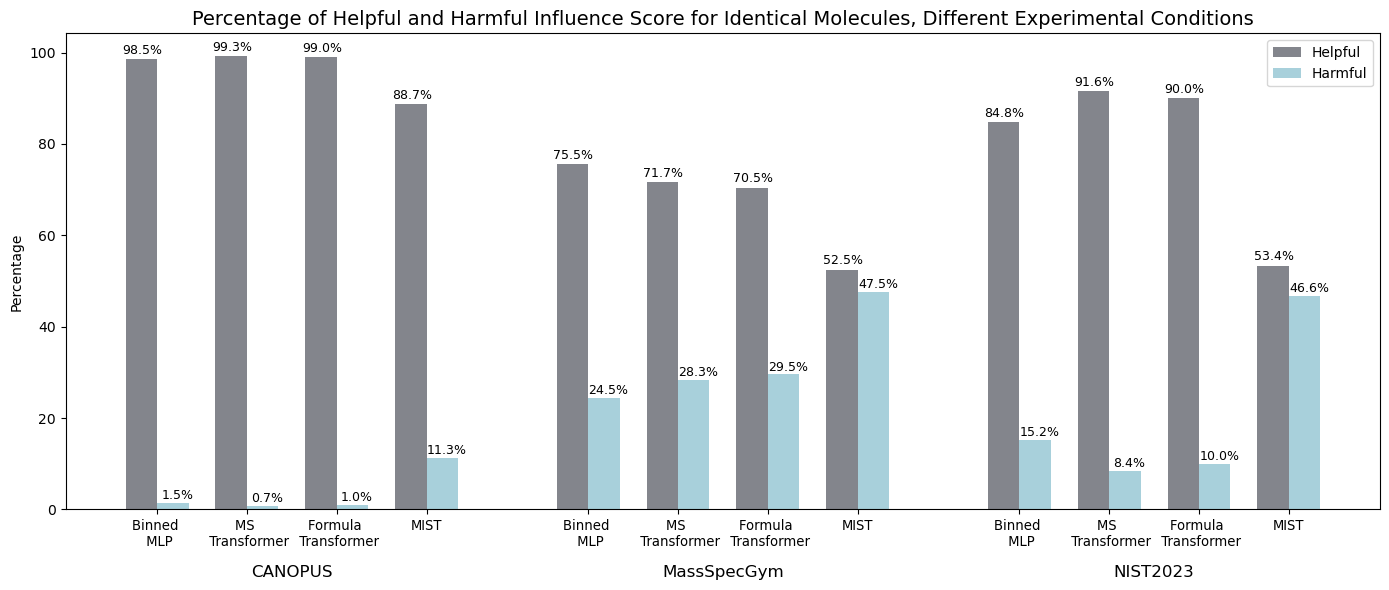

In [4]:
results_cache = [f for f in os.listdir(IF_cache_folder) if "random" in f]

datasets = ["C", "MSG", "NIST2023"]
models = ["binned_", "MS_", "formula_", "MIST_"] #"binned_", "MS_", "formula_", 

# Get the percentage positive and negative for identical molecules for each model and dataset 
helpful_percent, harmful_percent = [], []

for dataset in datasets:

    for model in models: 

        results_path = [f for f in results_cache if dataset in f and model in f if "sieved" not in f]
        assert len(results_path) == 1
        results_path = os.path.join(IF_cache_folder, results_path[0], "identical_mol_diff_expt_condition_helpful_harmful_counts.pkl")
        results = load_pickle(results_path)

        helpful = np.mean([v["helpful"] for v in results.values()]).item()
        harmful = np.mean([v["harmful"] for v in results.values()]).item()
        helpful_percent.append(round(helpful * 100, 3))
        harmful_percent.append(round(harmful * 100, 3))

helpful_percent = np.array(helpful_percent).reshape(len(datasets), len(models))
harmful_percent = np.array(harmful_percent).reshape(len(datasets), len(models))

# Parameters
bar_width = 0.35
bar_spacing = 1.0
group_spacing = 0.8
n_models = len(models)

# Compute positions
x_positions = []
model_labels = []
dataset_boundaries = []

for d_idx, dataset in enumerate(datasets):
    group_start = d_idx * (n_models * bar_spacing + group_spacing)
    group_centers = []

    for m_idx, model in enumerate(models):
        center = group_start + m_idx * bar_spacing + (bar_width / 2)
        x_positions.append(center)
        model_labels.append(model_mapping[model])
        group_centers.append(center)

    dataset_boundaries.append(np.mean(group_centers))

# Flatten data
pos_flat = [p for group in helpful_percent for p in group]
neg_flat = [n for group in harmful_percent for n in group]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

x_positions = np.array(x_positions)
ax.bar(x_positions - bar_width/2, pos_flat, bar_width, label='Helpful', color = helpful_color_code)
ax.bar(x_positions + bar_width/2, neg_flat, bar_width, label='Harmful', color = harmful_color_code)

# Main x-axis: model labels
ax.set_xticks(x_positions)
ax.set_xticklabels(model_labels, fontsize = 9.5)
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Helpful and Harmful Influence Score for Identical Molecules, Different Experimental Conditions', fontsize=14)
ax.legend()

# Secondary x-axis for dataset grouping
ax2 = ax.secondary_xaxis('bottom')
ax2.set_xticks(dataset_boundaries)
ax2.set_xticklabels([dataset_mapping[d] for d in datasets])
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(axis='x', length=0, pad=40, labelsize=12)

# Add text labels
for xpos, height in zip(x_positions - bar_width/2, pos_flat):
    ax.text(xpos + 0.01, height + 0.5, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

for xpos, height in zip(x_positions + bar_width/2, neg_flat):
    ax.text(xpos + 0.05, height + 0.2, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(IF_plots_folder, "IF_identical_diff_expt_mol_helpful_harmful.png"), bbox_inches='tight')

plt.show()

`` Task 1: Understand what harms predictions ``

1. Look at the worst mistakes and we aim to answer the following questions: 

    - What are actually harmful
    - Why are they harmful

``Hypothesis 1: molecule similarity``

Maybe the more different the molecule, the more harmful it is?

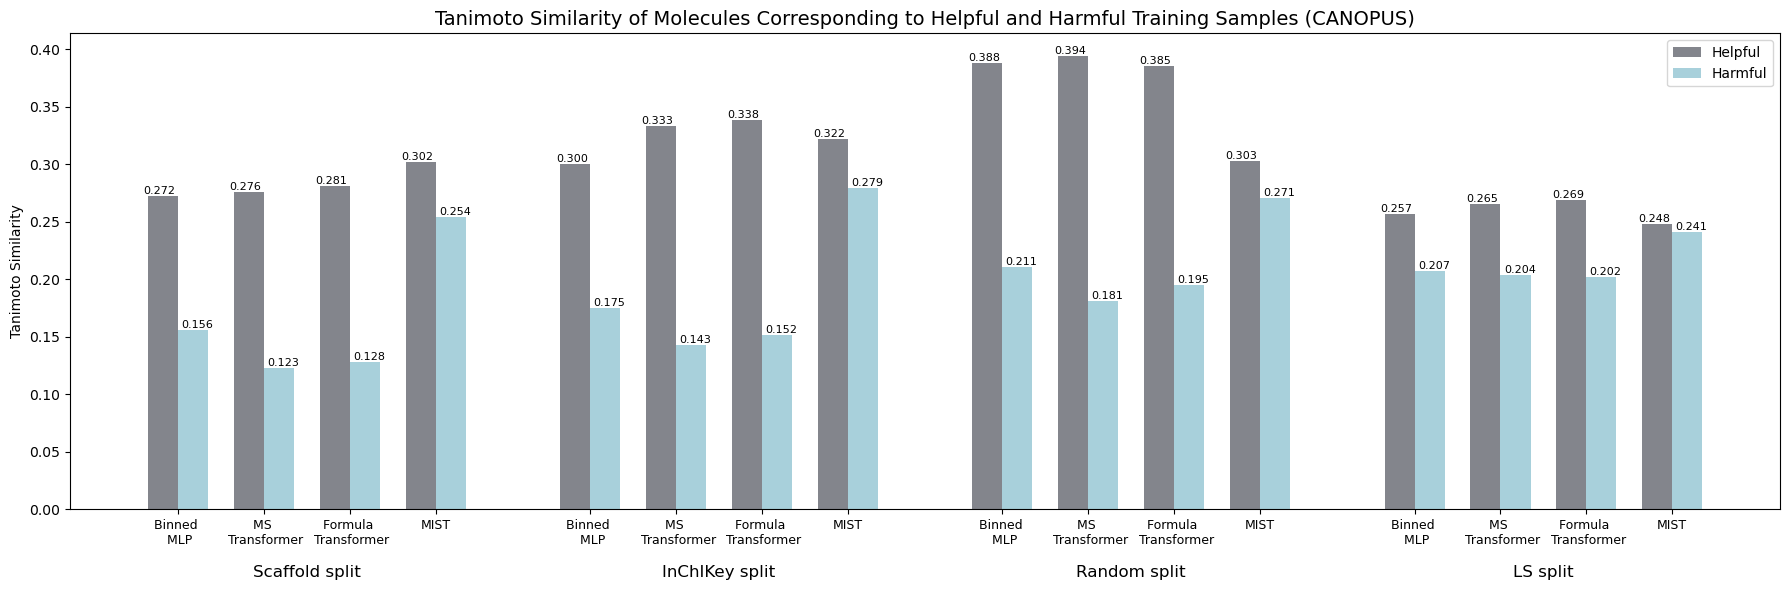

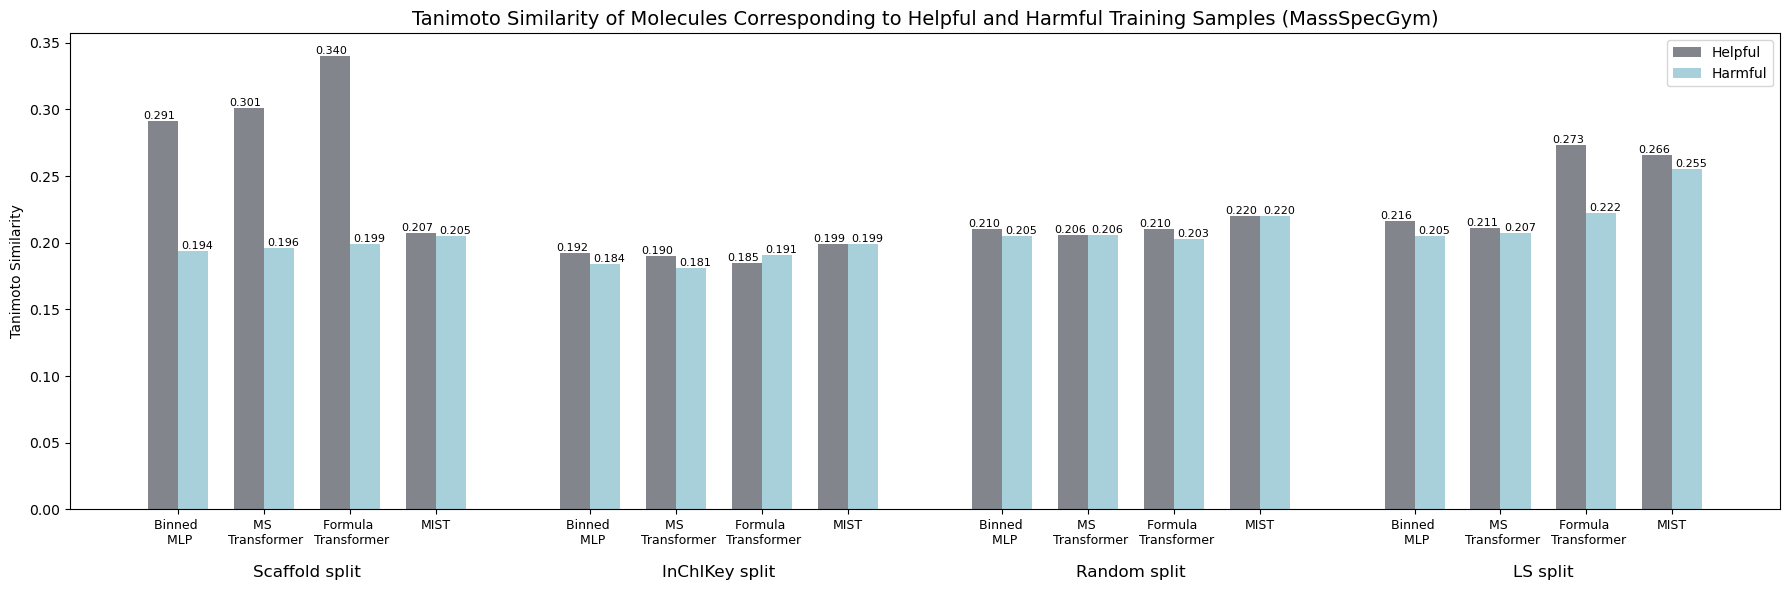

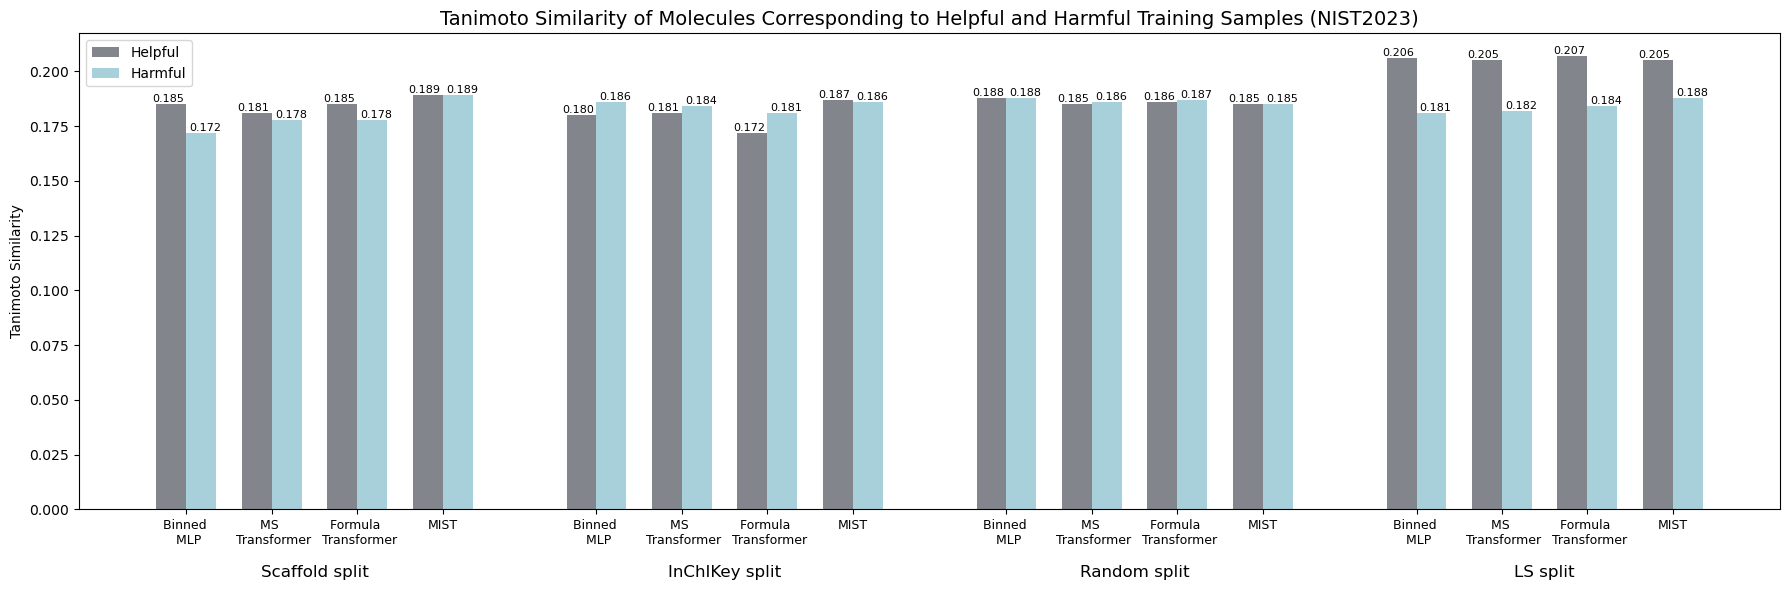

In [12]:
results_cache = [f for f in os.listdir(IF_cache_folder)]

for dataset in ["C", "MSG", "NIST2023"]:

    splits = ["scaffold_vanilla", "inchikey_vanilla", "random", "LS"]
    models = ["binned_", "MS_", "formula_", "MIST_"]

    # Get the percentage positive and negative for identical molecules for each model and dataset 
    helpful_sim, harmful_sim = [], []

    for split in splits:

        for model in models: 
            
            results_path = [f for f in results_cache if split in f and model in f and dataset in f if "sieved" not in f]
            assert len(results_path) == 1
            
            results_path = os.path.join(IF_cache_folder, results_path[0], "mol_sim_helpful_harmful.pkl")
            results = load_pickle(results_path)

            helpful = np.mean([np.mean(list(v["helpful"].values())) for v in results.values()]).item()
            harmful = np.mean([np.mean(list(v["harmful"].values())) for v in results.values()]).item()

            helpful_sim.append(round(helpful, 3))
            harmful_sim.append(round(harmful, 3))

    helpful_sim = np.array(helpful_sim).reshape(len(splits), len(models))
    harmful_sim = np.array(harmful_sim).reshape(len(splits), len(models))

    # Parameters
    bar_width = 0.35
    bar_spacing = 1.0
    group_spacing = 0.8
    n_models = len(models)

    # Compute positions
    x_positions = []
    model_labels = []
    split_boundaries = []

    for s_idx, split in enumerate(splits):
        group_start = s_idx * (n_models * bar_spacing + group_spacing)
        group_centers = []

        for m_idx, model in enumerate(models):
            center = group_start + m_idx * bar_spacing + (bar_width / 2)
            x_positions.append(center)
            model_labels.append(model_mapping[model])
            group_centers.append(center)

        split_boundaries.append(np.mean(group_centers))

    # Flatten data
    pos_flat = [p for group in helpful_sim for p in group]
    neg_flat = [n for group in harmful_sim for n in group]

    # Plot
    fig, ax = plt.subplots(figsize=(18, 6))

    x_positions = np.array(x_positions)
    ax.bar(x_positions - bar_width/2, pos_flat, bar_width, label='Helpful', color= helpful_color_code)
    ax.bar(x_positions + bar_width/2, neg_flat, bar_width, label='Harmful', color= harmful_color_code)

    # Main x-axis: model labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(model_labels, fontsize = 9)
    ax.set_ylabel('Tanimoto Similarity')
    ax.set_title(f'Tanimoto Similarity of Molecules Corresponding to Helpful and Harmful Training Samples ({dataset_mapping[dataset]})', fontsize=14)
    ax.legend()

    # Secondary x-axis for dataset grouping
    ax2 = ax.secondary_xaxis('bottom')
    ax2.set_xticks(split_boundaries)
    ax2.set_xticklabels([split_mapping[s] for s in splits])
    ax2.spines['bottom'].set_visible(False)
    ax2.tick_params(axis='x', length=0, pad=40, labelsize=12)

    # Add text labels
    for xpos, height in zip(x_positions - bar_width/2, pos_flat):
        ax.text(xpos - 0.04, height, f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    for xpos, height in zip(x_positions + bar_width/2, neg_flat):
        ax.text(xpos + 0.05, height, f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(IF_plots_folder, f"mol_sim_helpful_harmful_{dataset_mapping[dataset]}.png"), bbox_inches='tight')

    plt.show()

`` Hypothesis 2: Spectra similarity ``

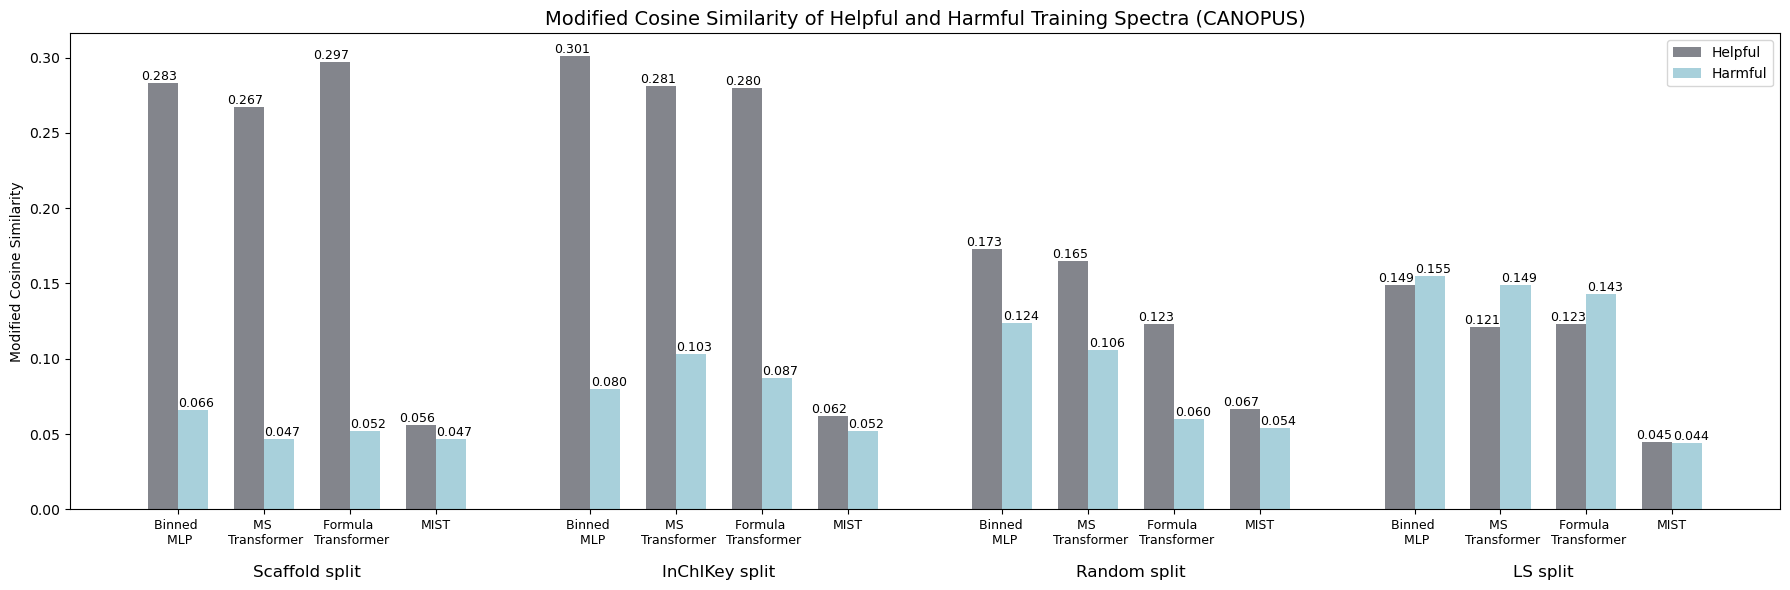

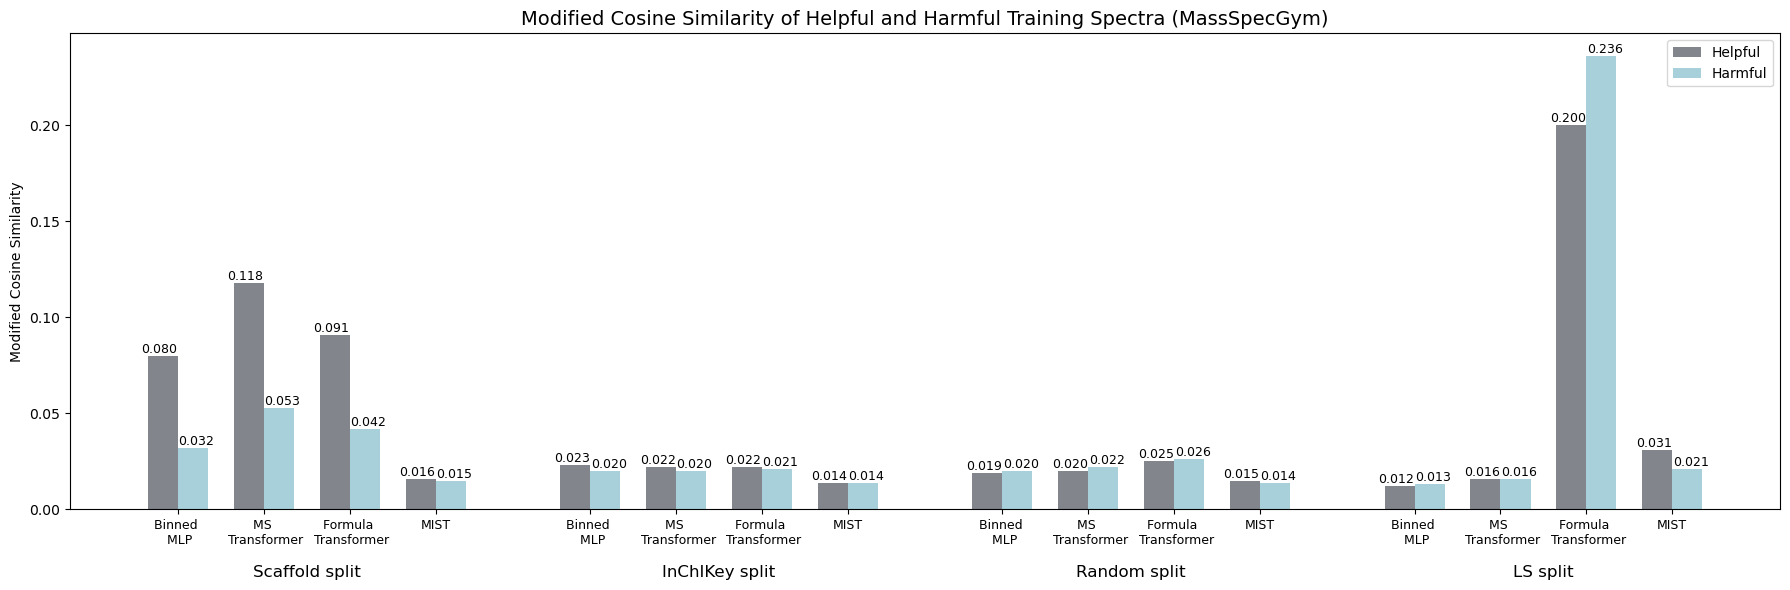

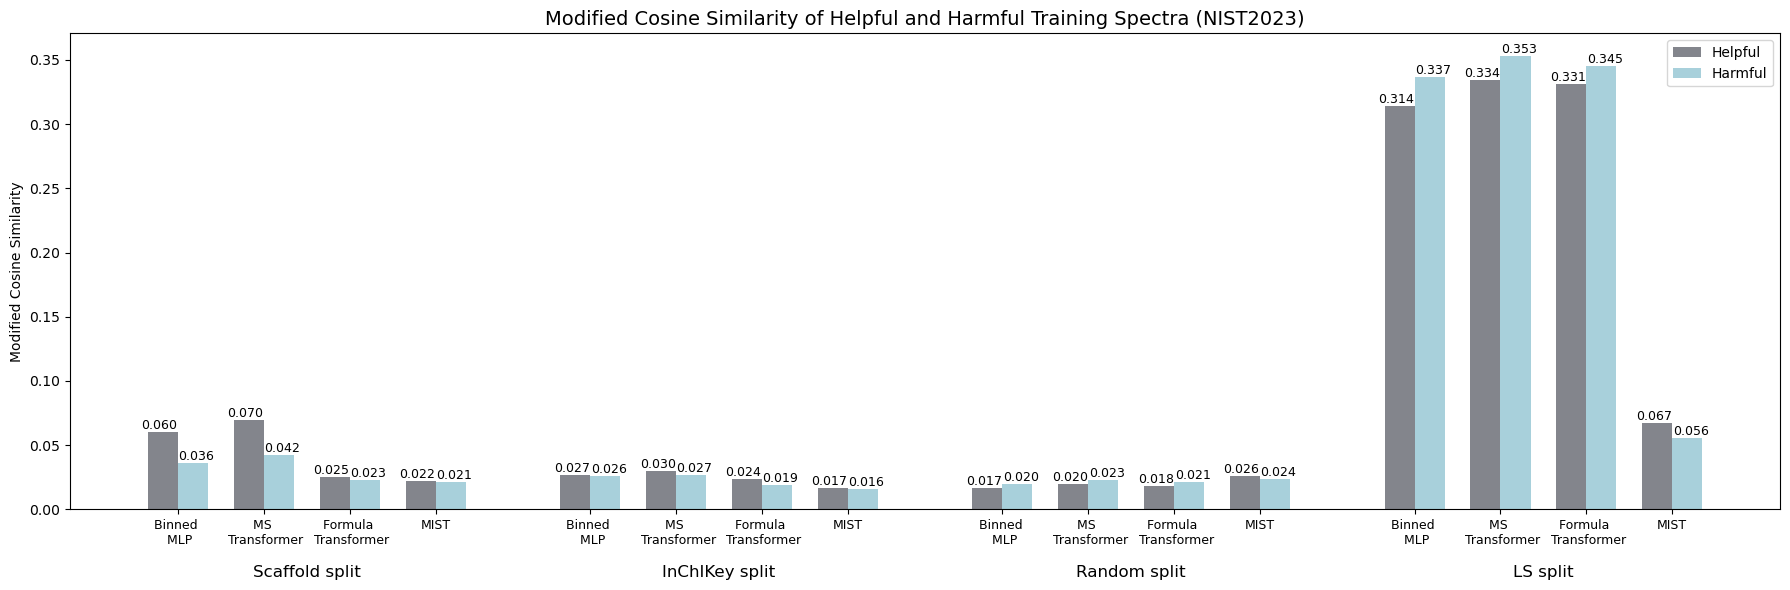

In [13]:
results_cache = [f for f in os.listdir(IF_cache_folder)]

for dataset in ["C", "MSG", "NIST2023"]:

    splits = ["scaffold_vanilla", "inchikey_vanilla", "random", "LS"]
    models = ["binned_", "MS_", "formula_", "MIST_"] #"binned_", "MS_", "formula_", 

    # Get the percentage positive and negative for identical molecules for each model and dataset 
    helpful_sim, harmful_sim = [], []

    for split in splits:

        for model in models: 
            
            results_path = [f for f in results_cache if split in f and model in f and dataset in f if "sieved" not in f]
            assert len(results_path) == 1
            
            results_path = os.path.join(IF_cache_folder, results_path[0], "MS_sim_helpful_harmful.pkl")
            # print(results_path, os.path.exists(results_path))
            # continue
            results = load_pickle(results_path)
            

            helpful = np.mean([np.mean(list(v["helpful"].values())) for v in results.values()]).item()
            harmful = np.mean([np.mean(list(v["harmful"].values())) for v in results.values()]).item()

            helpful_sim.append(round(helpful, 3))
            harmful_sim.append(round(harmful, 3))

    helpful_sim = np.array(helpful_sim).reshape(len(splits), len(models))
    harmful_sim = np.array(harmful_sim).reshape(len(splits), len(models))

    # Parameters
    bar_width = 0.35
    bar_spacing = 1.0
    group_spacing = 0.8
    n_models = len(models)

    # Compute positions
    x_positions = []
    model_labels = []
    split_boundaries = []

    for s_idx, split in enumerate(splits):
        group_start = s_idx * (n_models * bar_spacing + group_spacing)
        group_centers = []

        for m_idx, model in enumerate(models):
            center = group_start + m_idx * bar_spacing + (bar_width / 2)
            x_positions.append(center)
            model_labels.append(model_mapping[model])
            group_centers.append(center)

        split_boundaries.append(np.mean(group_centers))

    # Flatten data
    pos_flat = [p for group in helpful_sim for p in group]
    neg_flat = [n for group in harmful_sim for n in group]

    # Plot
    fig, ax = plt.subplots(figsize=(18, 6))

    x_positions = np.array(x_positions)
    ax.bar(x_positions - bar_width/2, pos_flat, bar_width, label='Helpful', color= helpful_color_code)
    ax.bar(x_positions + bar_width/2, neg_flat, bar_width, label='Harmful', color= harmful_color_code)

    # Main x-axis: model labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(model_labels, fontsize = 9)
    ax.set_ylabel('Modified Cosine Similarity')
    ax.set_title(f'Modified Cosine Similarity of Helpful and Harmful Training Spectra ({dataset_mapping[dataset]})', fontsize=14)
    ax.legend()

    # Secondary x-axis for dataset grouping
    ax2 = ax.secondary_xaxis('bottom')
    ax2.set_xticks(split_boundaries)
    ax2.set_xticklabels([split_mapping[s] for s in splits])
    ax2.spines['bottom'].set_visible(False)
    ax2.tick_params(axis='x', length=0, pad=40, labelsize=12)

    # Add text labels
    for xpos, height in zip(x_positions - bar_width/2, pos_flat):
        ax.text(xpos - 0.04, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    for xpos, height in zip(x_positions + bar_width/2, neg_flat):
        ax.text(xpos + 0.04, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(IF_plots_folder, f"MS_sim_helpful_harmful_{dataset_mapping[dataset]}.png"), bbox_inches='tight')

    plt.show()


`` Hypothesis 3: consistency between spectra and molecule similarity ``

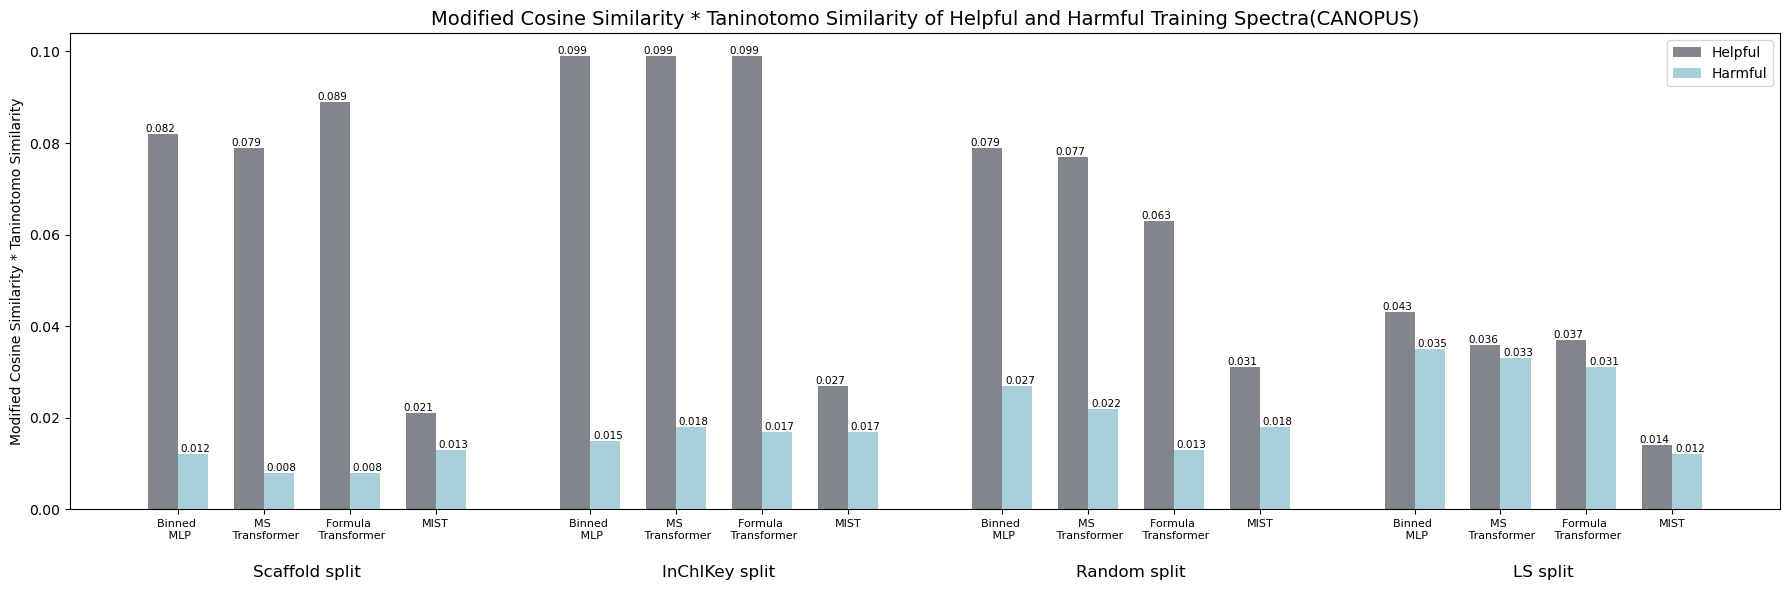

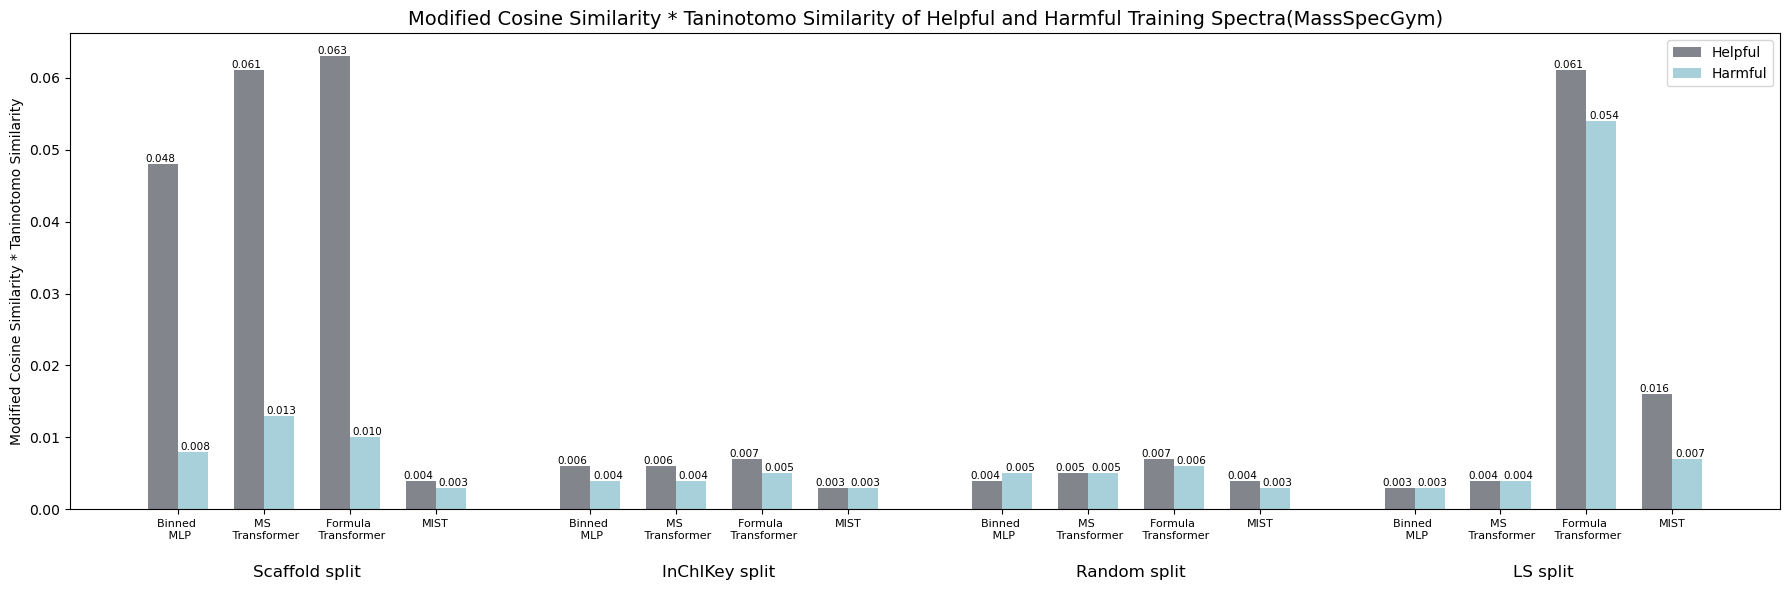

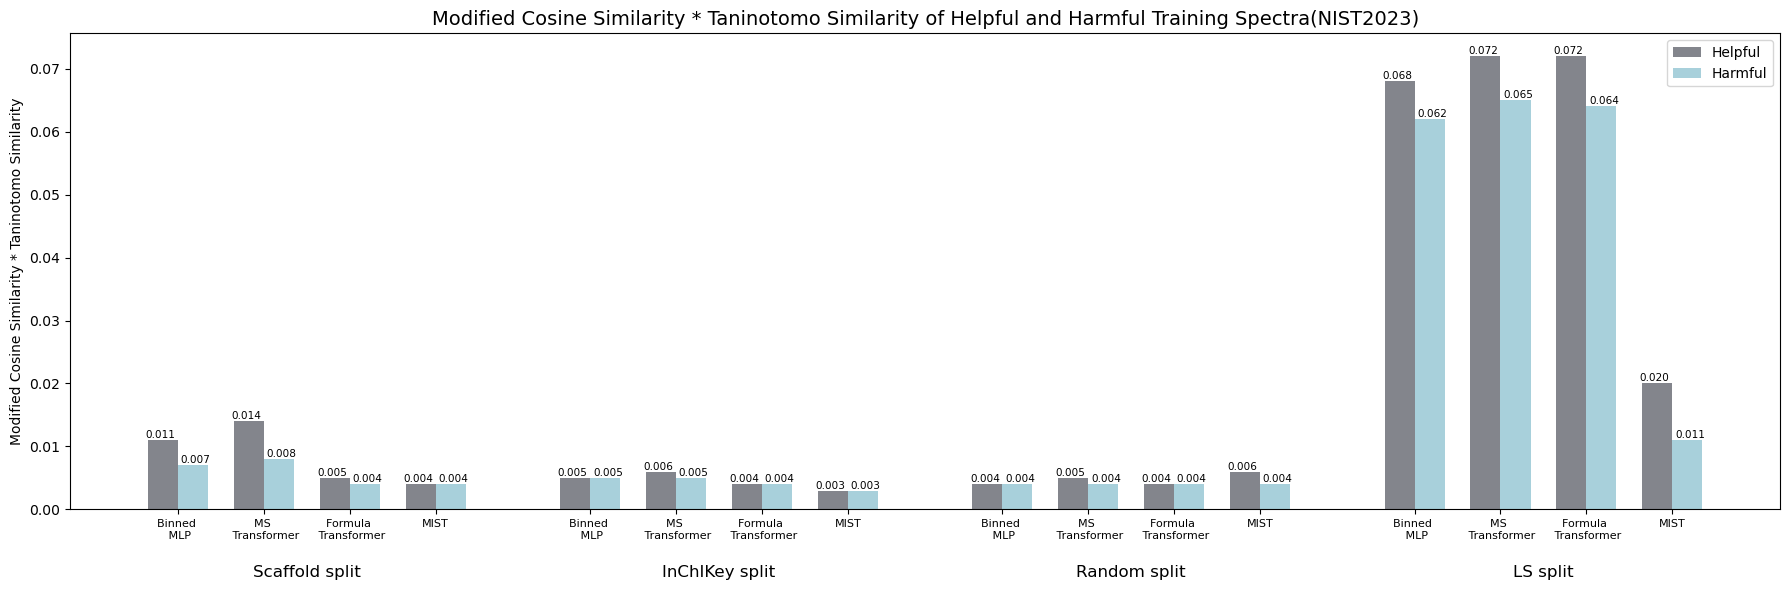

In [20]:
results_cache = [f for f in os.listdir(IF_cache_folder)]

for dataset in ["C", "MSG", "NIST2023"]:

    splits = ["scaffold_vanilla", "inchikey_vanilla", "random", "LS"]
    models = ["binned_", "MS_", "formula_", "MIST_"] # 

    # Get the percentage positive and negative for identical molecules for each model and dataset 
    helpful_sim, harmful_sim = [], []

    for split in splits:

        for model in models: 
            
            results_path = [f for f in results_cache if split in f and model in f and dataset in f and "sieved" not in f]
            assert len(results_path) == 1
            
            results_path = os.path.join(IF_cache_folder, results_path[0], "mol_MS_sim_con_helpful_harmful.pkl")
            results = load_pickle(results_path)
        
            helpful = np.mean([np.mean(list(v["helpful"].values())) for v in results.values()]).item()
            harmful = np.mean([np.mean(list(v["harmful"].values())) for v in results.values()]).item()

            helpful_sim.append(round(helpful, 3))
            harmful_sim.append(round(harmful, 3))

    helpful_sim = np.array(helpful_sim).reshape(len(splits), len(models))
    harmful_sim = np.array(harmful_sim).reshape(len(splits), len(models))

    # Parameters
    bar_width = 0.35
    bar_spacing = 1.0
    group_spacing = 0.8
    n_models = len(models)

    # Compute positions
    x_positions = []
    model_labels = []
    split_boundaries = []

    for s_idx, split in enumerate(splits):
        group_start = s_idx * (n_models * bar_spacing + group_spacing)
        group_centers = []

        for m_idx, model in enumerate(models):
            center = group_start + m_idx * bar_spacing + (bar_width / 2)
            x_positions.append(center)
            model_labels.append(model_mapping[model])
            group_centers.append(center)

        split_boundaries.append(np.mean(group_centers))

    # Flatten data
    pos_flat = [p for group in helpful_sim for p in group]
    neg_flat = [n for group in harmful_sim for n in group]

    # Plot
    fig, ax = plt.subplots(figsize=(18, 6))

    x_positions = np.array(x_positions)
    ax.bar(x_positions - bar_width/2, pos_flat, bar_width, label='Helpful', color= helpful_color_code)
    ax.bar(x_positions + bar_width/2, neg_flat, bar_width, label='Harmful', color= harmful_color_code)

    # Main x-axis: model labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(model_labels, fontsize = 8)
    ax.set_ylabel('Modified Cosine Similarity * Taninotomo Similarity')
    ax.set_title(f'Modified Cosine Similarity * Taninotomo Similarity of Helpful and Harmful Training Spectra({dataset_mapping[dataset]})', fontsize=14)
    ax.legend()

    # Secondary x-axis for dataset grouping
    ax2 = ax.secondary_xaxis('bottom')
    ax2.set_xticks(split_boundaries)
    ax2.set_xticklabels([split_mapping[s] for s in splits])
    ax2.spines['bottom'].set_visible(False)
    ax2.tick_params(axis='x', length=0, pad=40, labelsize=12)

    # Add text labels
    for xpos, height in zip(x_positions - bar_width/2, pos_flat):
        ax.text(xpos - 0.03, height, f'{height:.3f}', ha='center', va='bottom', fontsize=7.5)

    for xpos, height in zip(x_positions + bar_width/2, neg_flat):
        ax.text(xpos + 0.03, height, f'{height:.3f}', ha='center', va='bottom', fontsize=7.5)

    plt.tight_layout()
    plt.savefig(os.path.join(IF_plots_folder, f"ms_mol_sim_cons_helpful_harmful_{dataset_mapping[dataset]}.png"), bbox_inches='tight')

    plt.show()
